# Предварительный анализ данных для текстов

Во время работы с данными важно понять, что они собой представляют. Не всегда на первый взгляд можно понять их структуру, свойства и особенности. В частности, это касается и текстовых данных, которые сами по себе не имеют четкой структуры. Для этого существует EDA (Exploratory data analysis), или разведочный анализ данных.

In [1]:
#!pip install --upgrade jupyter_client jupyter

## Первичный анализ датасета

Сначала необходимо установить все необходимые библиотеки и импортировать их.

In [2]:
pip install gensim

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
import spacy
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import ast

from collections import Counter

import pandas as pd
import numpy as np
import json

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Для демонстрации возьмем [открытый датасет с Kaggle, представляющий собой набор рецептов](https://www.kaggle.com/datasets/prashantsingh001/recipes-dataset-64k-dishes).

In [4]:
# Прочитаем файлы с данными и изучим их

try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/1_Recipe_csv.csv')
except:
    df = pd.read_csv('1_Recipe_csv.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the dipping sauce—it's worth it.","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablespoon Worcestershire sauce"", ""1/2 teaspoon onion powder"", ""1/4 teaspoon cayenne"", ""2 baking potatoes"", ""olive oil cooking spray"", ""1/2 teaspoon garlic powder"", ""salt and freshly ground black pepper""]","[""Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat, and cool. Cover and store in the refrigerator until ready to use."", ""Preheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or line with a disposable parchment liner."", ""Slice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. Spray potatoes with olive oil spray, and sprinkle with garlic powder, salt and pepper. Give the potatoes a good stir."", ""Place potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they start to crisp up a bit and turn golden brown, 14 to 17 minutes. Cooking times can vary depending on the brand and size of the fryer, and you may have to cook in batches."", ""Remove from the fryer, and serve with beer ketchup dipping sauce.""]",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,"These gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicious. Whether you finish them with the gochujang sauce in the air fryer, or just dip them in the sauce at the end, they are irresistibly good.","[""1 pound pork belly"", ""1/4 cup gochujang"", ""2 tablespoons soy sauce"", ""1 tablespoon honey,"", ""1 teaspoon ground ginger""]","[""Preheat an air fryer to 400 degrees F (200 degrees C)."", ""Place pork belly pieces in the basket in a single layer, not touching. Air fry for 8 to 9 minutes; turn over and air fry for 6 to 7 minutes more."", ""Meanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl."", ""Remove pork belly from air fryer basket; toss in sauce to coat. Return to the air fryer and fry until bites begin to char at the edges, 8 to 11 minutes more. (Alternately, you can use sauce only for dipping; in this case, continue to fry without removing bites, until they begin to char, 6 to 7 minutes.)""]",5,4
2,3-Ingredient Air Fryer Everything Bagel Chicken Strips,Air Fryer Recipes,Air Fryer Recipes,"These 3-ingredient air fryer everything bagel chicken strips are simple, flavorful, and delicious. Chicken tenders are easy to cook, but this easy? Wow! 5 minutes of prep time, 3 ingredients, and a quick fry in the air fryer, and dinner is ready in well under half an hour. My go-to dipping sauces are ranch dressing, brown gravy, or tartar sauce made with dill relish.","[""1 \u00bc pounds chicken tenders"", ""1 tablespoon olive oil"", ""1/3 cup everything bagel seasoning or to taste""]","[""Gather all ingredients. Preheat an air fryer to 400 degrees F (200 degrees C), or according to manufacturer's instructions."", ""Place tenders in a bowl. Add oil and toss to coat. Add everything seasoning and toss to coat again."", ""Place tenders in the air fryer basket in a single layer; cook in batches if necessary. Cook until no longer pink at the center and juices run clear, about 12 minutes. An instant read thermometer inserted near the center should read at least 165 degrees F (74 degrees C)."", ""Transfer to a serving plate and serve with desired dipping sauce.""]",3,4
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,"These air fryer everything bagel chicken cutlets, breaded with everything-seasoned p

In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     62126 non-null  object
 1   category         62126 non-null  object
 2   subcategory      62126 non-null  object
 3   description      62126 non-null  object
 4   ingredients      62126 non-null  object
 5   directions       62126 non-null  object
 6   num_ingredients  62126 non-null  int64 
 7   num_steps        62126 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


Как сказано в описании, данные содержат название рецепта, категорию и подкатегорию, список ингредиентов, пошаговую инструкцию, а также количества ингредиентов и шагов.

Проверим данные на наличие пропусков и дубликатов

In [7]:
display(df.isna().sum())
display(df.duplicated().sum())

,0
recipe_title,0
category,0
subcategory,0
description,0
ingredients,0
directions,0
num_ingredients,0
num_steps,0


np.int64(0)

Пропусков и дубликатов не найдено.

Изучим имеющиемя данные по длине и частотности.
Для упрощения демонстрации анализа создадим столбец с рецептами в виде текста. Объединим в единый текст последовательность шагов в столбце `directions` (пошаговая инструкция рецепта).


In [8]:
df['directions_str'] = df['directions'].map(lambda x: "\n\n".join(json.loads(x)))
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps,directions_str
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the dipping sauce—it's worth it.","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablespoon Worcestershire sauce"", ""1/2 teaspoon onion powder"", ""1/4 teaspoon cayenne"", ""2 baking potatoes"", ""olive oil cooking spray"", ""1/2 teaspoon garlic powder"", ""salt and freshly ground black pepper""]","[""Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat, and cool. Cover and store in the refrigerator until ready to use."", ""Preheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or line with a disposable parchment liner."", ""Slice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. Spray potatoes with olive oil spray, and sprinkle with garlic powder, salt and pepper. Give the potatoes a good stir."", ""Place potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they start to crisp up a bit and turn golden brown, 14 to 17 minutes. Cooking times can vary depending on the brand and size of the fryer, and you may have to cook in batches."", ""Remove from the fryer, and serve with beer ketchup dipping sauce.""]",9,5,"Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat, and cool. Cover and store in the refrigerator until ready to use.\n\nPreheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or line with a disposable parchment liner.\n\nSlice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. Spray potatoes with olive oil spray, and sprinkle with garlic powder, salt and pepper. Give the potatoes a good stir.\n\nPlace potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they start to crisp up a bit and turn golden brown, 14 to 17 minutes. Cooking times can vary depending on the brand and size of the fryer, and you may have to cook in batches.\n\nRemove from the fryer, and serve with beer ketchup dipping sauce."
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,"These gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicious. Whether you finish them with the gochujang sauce in the air fryer, or just dip them in the sauce at the end, they are irresistibly good.","[""1 pound pork belly"", ""1/4 cup gochujang"", ""2 tablespoons soy sauce"", ""1 tablespoon honey,"", ""1 teaspoon ground ginger""]","[""Preheat an air fryer to 400 degrees F (200 degrees C)."", ""Place pork belly pieces in the basket in a single layer, not touching. Air fry for 8 to 9 minutes; turn over and air fry for 6 to 7 minutes more."", ""Meanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl."", ""Remove pork belly from air fryer basket; toss in sauce to coat. Return to the air fryer and fry until bites begin to char at the edges, 8 to 11 minutes more. (Alternately, you can use sauce only for dipping; in this case, continue to fry without removing bites, until they begin to char, 6 to 7 minutes.)""]",5,4,"Preheat an air fryer to 400 degrees F (200 degrees C).\n\nPlace pork belly pieces in the basket in a single layer, not touching. Air fry for 8 to 9 minutes; turn over and air fry for 6 to 7 minutes more.\n\nMeanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl.\n\nRemove pork belly from air fryer basket; toss in sauce to coat. Return to the air fryer a

Построим гистограммы распределения количества символов в каждом рецепте.

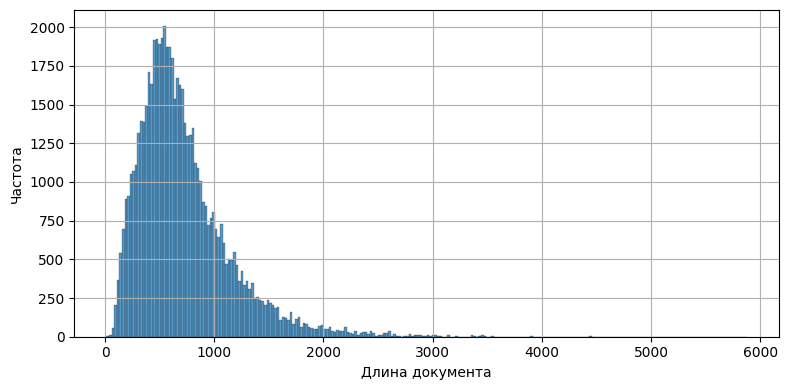

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(df['directions_str'].str.len())
plt.xlabel('Длина документа')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()

In [10]:
df['directions_str'].str.len().min(), df['directions_str'].str.len().max()

(12, 5879)

Видим, что длина рецептов составляет от 12 до 5879 символов, а также по гистограмме можно сделать вывод, что чаще всего длина рецепта примерно равна от 100 до 1000 символов. Реже бывают длинные рецепты с более чем 2000 символами.

Теперь построим диаграмму на основе количества слов.

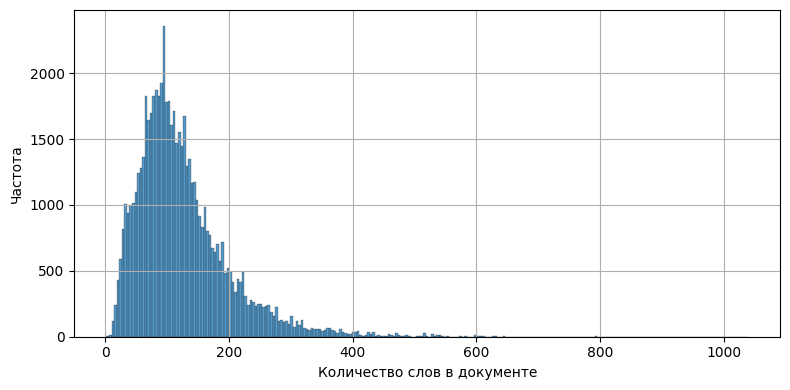

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(df['directions_str'].str.split().map(lambda x: len(x)))
plt.xlabel('Количество слов в документе')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()

In [12]:
df['directions_str'].str.split().map(lambda x: len(x)).min(), df['directions_str'].str.split().map(lambda x: len(x)).max()

(2, 1039)

Видим схожую картину. Длина рецептов составляет от 2 до 1039 слов, а также по гистограмме можно сделать вывод, что чаще всего количество слов в рецептах примерно равно от 50 до 200.

Теперь рассмотрим среднюю длину слова в предложениях.

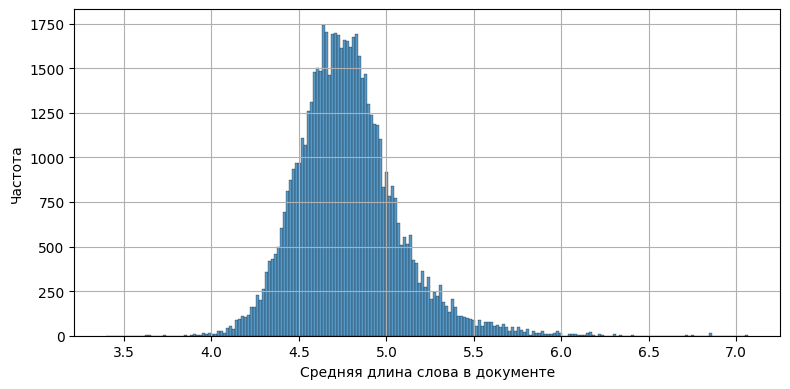

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(df['directions_str'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
plt.xlabel('Средняя длина слова в документе')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()

Здесь уже видим более «нормальное» распределение. На первый взгляд можно сказать, что длина слова в рецептах примерно от 4.5 до 5. Но стоит обратить внимание на такую вещь как — стоп слова.

Стоп‑слова — это предлоги, союзы, местоимения, частицы и другие часто встречающиеся слова, которые связывают текст, и не всегда добавляют ценной информации. (например в русском языке: ну, а, и, и так далее).

Чтобы получить список стоп‑слов можно воспользоваться библиотекой [nltk](https://www.nltk.org/).

In [14]:
# Загрузка стоп-слов
nltk.download('stopwords')
stop=set(stopwords.words('english'))
print(stop)

{'were', 'hers', 'isn', 'that', "she'll", "don't", "she's", "it'll", 'aren', "i'll", 'more', 'here', "they're", 'above', "he's", 'herself', 'me', 'doing', "you're", "we'd", 'itself', 'than', 'needn', 'at', "couldn't", 'from', "it'd", 'their', 'won', "i'd", 'now', 'do', 'own', 'by', 'same', 'll', 'weren', 'yourselves', 'an', 'ain', 'couldn', "needn't", 'can', 'wasn', 're', 'only', 'did', 'didn', 'was', 'what', 'then', "didn't", 'who', 'nor', "we've", "doesn't", "haven't", 'under', "i'm", "mightn't", 'other', 'be', 'or', 'should', 'o', 'are', 'about', 'yourself', 'they', 'not', "won't", 'it', 'no', 'him', 'through', 'haven', "shan't", 'such', 'why', 'before', "mustn't", 'had', 'having', 'in', 'all', 'her', 'on', 'theirs', 'between', 'which', 'of', "it's", 'when', 'his', 'wouldn', 'ourselves', "i've", 'during', "you've", 'i', 'my', "you'd", "they'll", 'off', 'whom', 'too', "that'll", 'been', "aren't", 'if', 'just', 'shouldn', "he'd", 'the', 'again', "should've", 'down', 'while', 'y', 'ma'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Также стоп‑слова можно получить и для русского языка
stop_ru = set(stopwords.words('russian'))
print(stop_ru)

{'из', 'она', 'тем', 'во', 'без', 'со', 'него', 'где', 'хоть', 'вдруг', 'свою', 'им', 'ее', 'его', 'тогда', 'никогда', 'этот', 'же', 'всех', 'себя', 'моя', 'чуть', 'ни', 'кто', 'нельзя', 'так', 'мой', 'нет', 'уж', 'чего', 'и', 'теперь', 'иногда', 'была', 'том', 'нее', 'впрочем', 'три', 'мне', 'ты', 'куда', 'нас', 'перед', 'чем', 'всю', 'этой', 'может', 'были', 'такой', 'он', 'после', 'всегда', 'чтобы', 'не', 'да', 'от', 'раз', 'если', 'эти', 'какой', 'тут', 'то', 'для', 'можно', 'нибудь', 'вас', 'было', 'опять', 'сейчас', 'с', 'про', 'ему', 'какая', 'а', 'под', 'до', 'ж', 'об', 'ничего', 'у', 'наконец', 'этого', 'больше', 'более', 'меня', 'совсем', 'ней', 'там', 'потом', 'что', 'чтоб', 'ним', 'при', 'почти', 'над', 'в', 'разве', 'ведь', 'лучше', 'только', 'другой', 'зачем', 'за', 'конечно', 'бы', 'как', 'между', 'вы', 'по', 'два', 'или', 'сам', 'будет', 'к', 'вам', 'того', 'они', 'о', 'но', 'есть', 'я', 'себе', 'всего', 'них', 'потому', 'когда', 'быть', 'уже', 'тоже', 'много', 'все', '

Посмотрим на статистику стоп‑слов в нашем корпусе текста. Для этого сначала соберем в единый список все имеющиеся слова в датасете рецептов.

In [16]:
corpus=[]
sentences = df['directions_str'].tolist()
corpus_words = [word for sentence in sentences for word in sentence.split()]

Теперь подсчитаем частоту встречаемости каждого стоп‑слова

In [17]:
count_words = {}
for word in corpus_words:
    if word in stop:
        count_words[word] = count_words.get(word, 0) + 1

Построим график частоты встречаемости стоп‑слов на диаграмме

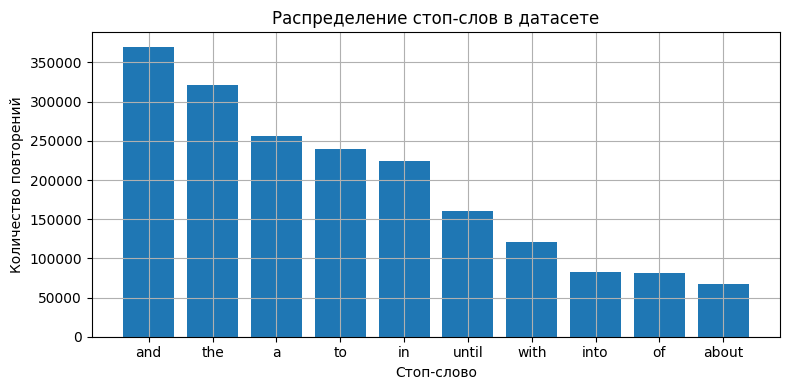

In [18]:
top_stop_words=sorted(count_words.items(), key=lambda x:x[1], reverse=True)[:10]
x, y =zip(*top_stop_words)
#stop_words_df = pd.DataFrame(y, columns = x)

plt.figure(figsize=(8, 4))
plt.bar(x, y)
plt.xlabel('Стоп-слово')
plt.ylabel('Количество повторений')
plt.title('Распределение стоп‑слов в датасете')
plt.grid()
plt.tight_layout()

Видим, что наиболее часто встречающиеся стоп‑слова это *and*, *the*, *a*.

Также мы можем посчитать наиболее часто встречающиеся слова во всем корпусе текста.

Посчитаем частоту слов во всем корпусе, исключая при этом стоп‑слова:

In [19]:
counter = Counter(corpus_words)
most=counter.most_common()
x, y= [], []
for word,count in most[:40]:
    if (word not in stop) and len(word) > 1:
        x.append(word)
        y.append(count)

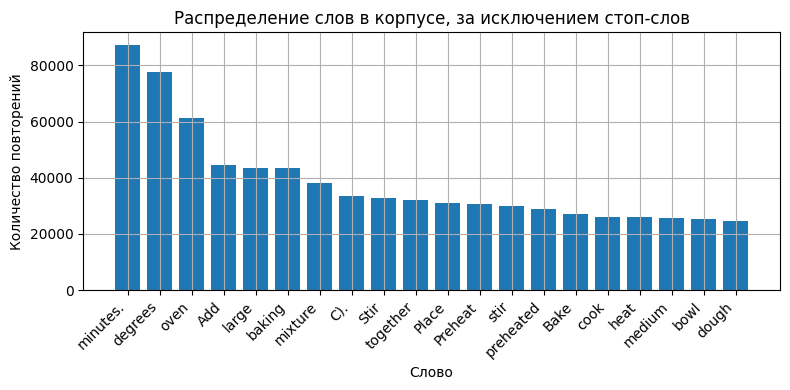

In [20]:
# отображение текста
plt.figure(figsize=(8, 4))
plt.bar(x, y)
plt.xlabel('Cлово')
plt.ylabel('Количество повторений')
plt.title('Распределение слов в корпусе, за исключением стоп‑слов')
plt.grid()
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()


Видим следующее: одни из наиболее популярных слов в корпусе это: *minutes*, *degrees* и *oven*. Кажется достаточно очевидным для датасета с кулинарными рецептами.

Еще один способ визуализации частотности слов это `WordCloud` (или облако слов).



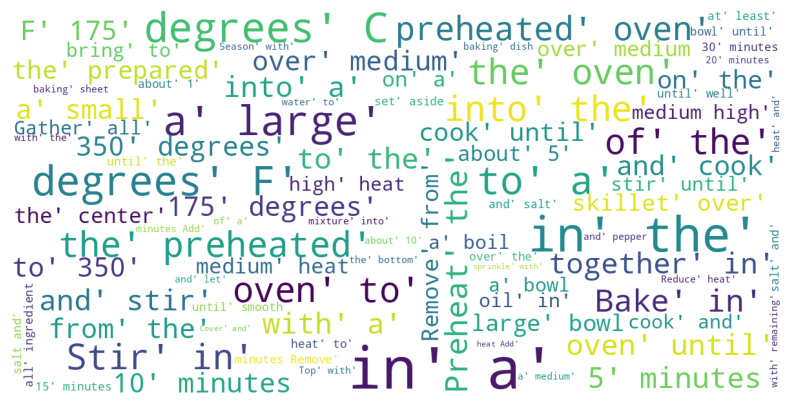

In [21]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(10, 18))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus_words)


Видим те же наиболее частые слова. В этом формате отображения можно настроить стоп‑слова, которые не будут отображаться, количество слов на изображении, максимальный размер слов и так далее.



Также для корпуса текста можно рассчитать показатель лексического богатства (или лексического разнообразия).

**Коэффициент лексического разнообразия (КЛР)** — это мера богатства лексики текста, которая показывает, насколько часто в нем встречаются уникальные слова по отношению к общему числу слов. Измеряется КЛР от 0 до 1. Чем больше это значение, тем более разнообразнее текст, и наоборот, чем меньше КЛР, тем лексически беднее текст.

Посчитаем КЛР для нашего датасета

In [22]:
lexical_diversity = (len(set(corpus_words)) / len(corpus_words)) * 100
print(f"{lexical_diversity=}")

lexical_diversity=0.29431734886771344


Значение примерно равно 0.3. Можно сделать вывод, что в данном корпусе рецептов относительно небольшое лексическое разнообразие слов (много повторений).



## Тематические моделирование

Тематическое моделирование — это метод статистического анализа, посредством которого извлекаются основные темы, встречающиеся в корпусе документов.

Рассмотрим такой вид анализа на примере одного из наиболее популярных методов тематического моделирования — `Latent Dirichlet Allocation (LDA)`.

Принцип `LDA` следующий:
1. Сначала текст переводится в векторное представление.
2. Метод LDA предполагает, что заранее будет указано количество тем в корпусе. Это может быть сложной задачей. Данный параметр подбирается в зависимости от знаний о данных или эмпирически во время экспериментов.
3. Происходит обучение модели LDA, которая итеративно обрабатывает тексты, и старается максимизировать появления слов в каждой теме и вероятность наличия тем в каждом документе.



Перед началом применения LDA необходимо провести подготовку данных, а именно:
1. провести токенизацию (разбить текст на массив слов);
2. удалить стоп‑слова;
3. лемматизировать (привести слова к начальной форме. Например: сделано — делать, прыгающий — прыгать).

Лемматизация необходима для того, чтобы убрать ситуации, когда одно и то же слово имеет разную форму, но одно и то же значение (например: делаю, делал, сделаю, …). Для LDA нам нужны именно уникальные слова.

Для подготовки текста воспользуемся библиотекой [spaCy](https://spacy.io/).


In [23]:
# установка ядра для spacy
nlp = spacy.load("en_core_web_sm", enable=["lemmatizer"])

# для ускорения берем часть от датасета
df_tmp = df.iloc[:10000]

all_lemmas = []
for text in df_tmp ['directions_str'].tolist():
    # Обрабатываем текст моделью spaCy
    doc = nlp(text)

    # Создаем список для хранения лемм, исключая стоп-слова и знаки препинания
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    all_lemmas.append(lemmas)

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [24]:
# Создаём словарь Gensim из всех лемм
dictionary = Dictionary(all_lemmas)  # каждый уникальный токен получает id

# Преобразуем каждый документ в вектор BOW (список (token_id, частота))
bow_corpus = [dictionary.doc2bow(doc) for doc in all_lemmas]

Теперь производим запуск LDA для осуществления тематического моделирования

In [25]:
# Количество тем — по числу уникальных категорий
num_topics = len(df_tmp['category'].unique())

# Используем УЖЕ ПОСТРОЕННЫЙ словарь (из предыдущего этапа)
# Это критически важно для соответствия corpus ↔ словарь
id2word = dictionary  # тот самый Dictionary, который вы создали ранее


# Строим LDA-модель
lda_model = LdaMulticore(
    corpus=bow_corpus,           # ваш BOW-корпус
    id2word=id2word,            # словарь, соответствующий корпусу
    num_topics=num_topics,      # количество тем
    passes=10,                 # число проходов по данным
    random_state=42,           # для воспроизводимости
    chunksize=100,             # размер чанка для обработки. Контролирует объём данных, обрабатываемых за итерацию (оптимально для памяти).
    alpha='symmetric',           # априорное распределение тем
    eta='symmetric'              # априорное распределение слов в темах
)

In [26]:
# Выведем топ-5 слов для каждой темы
for idx, topic in lda_model.print_topics(-1, 5):
    print(f'Тема {idx}: {topic}')

Тема 0: 0.144*"cocoa" + 0.094*"shape" + 0.076*"ball" + 0.073*"hands" + 0.066*"balls"
Тема 1: 0.224*"temperature" + 0.165*"room" + 0.124*"70" + 0.075*"generously" + 0.046*"spice"
Тема 2: 0.272*"muffin" + 0.187*"divide" + 0.136*"tops" + 0.085*"horizontally" + 0.078*"equal"
Тема 3: 0.135*"sauce" + 0.055*"cabbage" + 0.050*"rice" + 0.048*"buns" + 0.047*"beef"
Тема 4: 0.094*"heat" + 0.051*"

" + 0.051*"minutes" + 0.049*"medium" + 0.034*"cook"
Тема 5: 0.227*"floured" + 0.082*"fine" + 0.076*"frying" + 0.072*"fork" + 0.051*"breadcrumbs"
Тема 6: 0.093*"lemon" + 0.088*"juice" + 0.056*"food" + 0.049*"add" + 0.045*"processor"
Тема 7: 0.323*"pineapple" + 0.219*"slices" + 0.164*"juice" + 0.089*"lime" + 0.043*"rings"
Тема 8: 0.127*"cheese" + 0.067*"cream" + 0.054*"

" + 0.047*"spread" + 0.045*"layer"
Тема 9: 0.132*"cup" + 0.125*"1" + 0.089*"remaining" + 0.081*"1/2" + 0.062*"2"
Тема 10: 0.279*"turkey" + 0.150*"apple" + 0.138*"leaf" + 0.065*"slicing" + 0.039*"diameter"
Тема 11: 0.116*"degrees" + 0.085*"

In [27]:
#pip install pyLDAvis

Чтобы визуализировать полученный результат можно использовать библиотеку [pyLDAvis](https://github.com/bmabey/pyLDAvis)

In [28]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

# # Подготовка данных для визуализации
# vis_data = gensimvis.prepare(
#     lda_model,      # ваша обученная LDA-модель
#     bow_corpus,     # корпус в формате BOW
#     dictionary,      # словарь (Dictionary)
#     sort_topics=False  # сохраняет исходный порядок тем
# )

# # Отображение в Jupyter Notebook / VS Code
# pyLDAvis.display(vis_data)

Что вы увидите в визуализации
* Левая панель: облако слов для выбранной темы (размер = важность). Каждый круг — это выделенная тема. Размер круга — важность темы, относительно всего корпуса (большой круг — много рецептов в этой категории, маленький — наоборот). Расстояние между кругами — схожесть тем друг от друга (чем дальше, тем менее схожи).
* Правая панель: гистограмма показывает наиболее релевантные слова для выбранной темы.
* Слайдер: переключение между темами.
* Ползунок λ: регулировка веса слов (по умолчанию λ=1).

На диаграмме



Если не видно визуализацию, то сохраните в HTML-файл.

Откройте файл в любом браузере — там будет полная интерактивная панель с:
*облаком слов для каждой темы;
*слайдером для переключения между темами;
*графиком близости тем.

In [29]:
# Сохраняет интерактивную визуализацию в файл
# pyLDAvis.save_html(vis_data, 'lda_visualization.html')
# print("Визуализация сохранена в файл lda_visualization.html")

## EDA для классификации текста

Рассмотрим пример анализа данных для задачи классификации текста.

В качестве примера возьмем [датасет с Kaggle](https://www.kaggle.com/datasets/tanishqdublish/text-classification-documentation), который представляет собой набор текстовых документов, разделенным по различным категориям.

По описанию можно увидеть, что документы разделены на 5 классов: политика, спорт, технологии, развлечения и бизнес.

В датасете категории разделены цифрами, в описании сказано, что разделение меток следующее: политика= 0, спорт= 1, технологии= 2, развлечения = 3, бизнес = 4.

Переходим к анализу самих данных.

In [30]:
# Прочитаем файлы с данными и изучим их

try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/df_file.csv')
except:
    df = pd.read_csv('df_file.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
df.head()

,Text,Label
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n",0
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the Roy

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [33]:
# Проверим наличие пропусков и дубликатов.
display(df.isna().sum())
display(df.duplicated().sum())

,0
Text,0
Label,0


np.int64(98)

In [34]:
# в данных присутствует 98 дубликатов. Избавимся от них
df = df.drop_duplicates()


Рассмотрим распределение классов

In [35]:
df['Label'].value_counts(normalize=True)

,proportion
Label,
1,0.237424
4,0.236483
0,0.189469
3,0.173484
2,0.163141


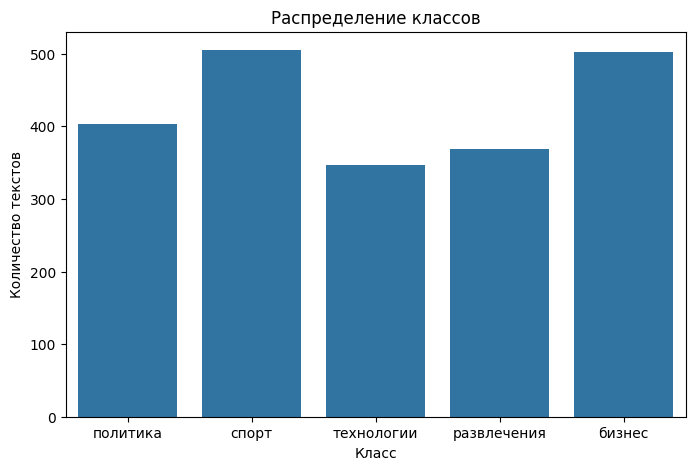

In [36]:
d_categories = {0: "политика", 1: "спорт", 2: "технологии", 3: "развлечения", 4: "бизнес"}

# переводим категории из цифр в названия
df['Label_str'] = df['Label'].map(d_categories)

plt.figure(figsize=(8, 5))
sns.countplot(x='Label_str', data=df)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество текстов')
plt.show()

Видим, что документов категорий «спорт» и «бизнес» чуть больше чем остальных, но в целом сильного дисбаланса классов в данных нет.

Попробуем посмотреть на зависимость длины текста и количества слов в документе с категорией. Для визуализации воспользуемся графиком «Ящик с усами».



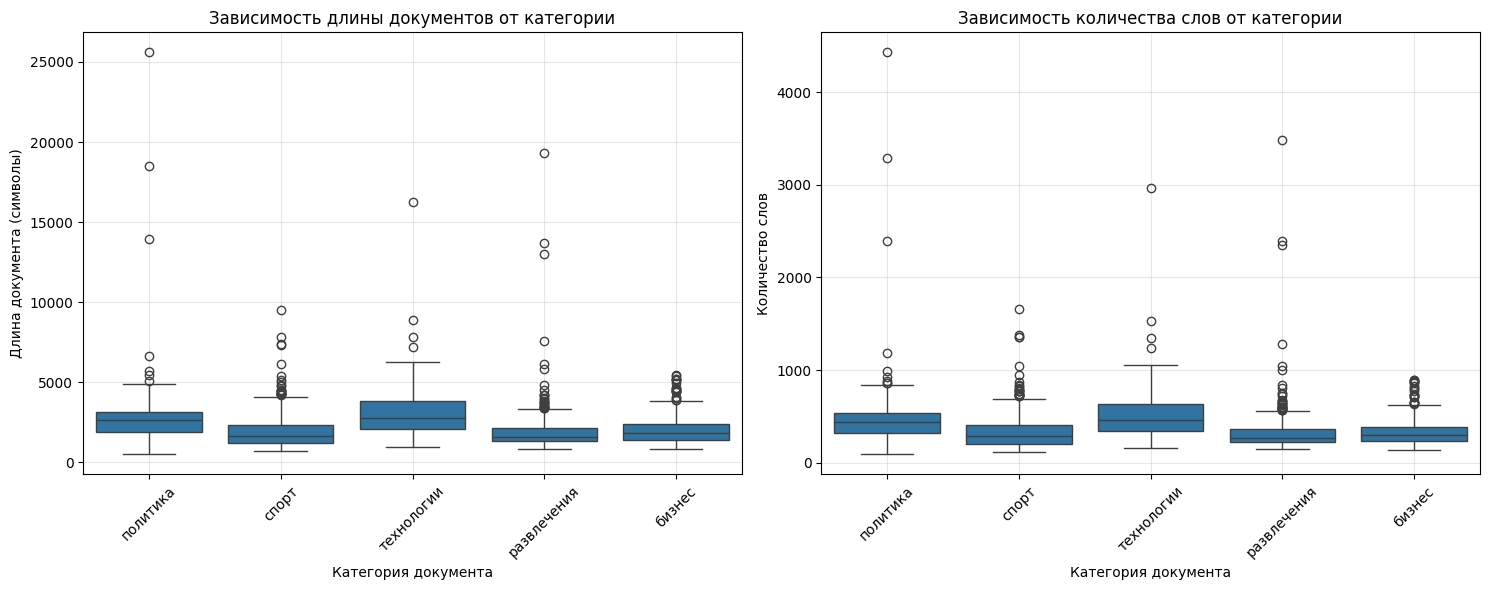

In [37]:
# считаем длину каждого документа и количество слов в каждом
df['text_length'] = df['Text'].apply(len)
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Левый график - длина документов
sns.boxplot(data=df, x='Label_str', y='text_length', ax=ax1)
ax1.set_title('Зависимость длины документов от категории')
ax1.set_xlabel('Категория документа')
ax1.set_ylabel('Длина документа (символы)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Правый график - количество слов
sns.boxplot(data=df, x='Label_str', y='word_count', ax=ax2)
ax2.set_title('Зависимость количества слов от категории')
ax2.set_xlabel('Категория документа')
ax2.set_ylabel('Количество слов')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()


Из графиков можно сделать вывод, что не наблюдается сильной зависимости категорий от длины документа и количества слов в документах, но видно, что в среднем документы с категориями «политика» и «технологии» имеют большую длину чем другие.

Дальше достаточно выполнить преобразование текста в числовой формат и применить любой классификатор.

## EDA для задач NER, POS

**NER (Named Entity Recognition)** — это задача автоматического поиска и классификации именованных сущностей в тексте (например, «[Организация Apple] планирует открыть офис в [Город Лондоне] в [Дата 2024 году]»).

**POS (Part-of-Speech)** — это задача определения грамматической роли каждого слова в предложении (например, «Красивая кошка грациозно прыгнула на стол» — «Прилагательное, Существительное, Наречие, Глагол, Предлог, Существительное»).

[Датасет снова возьмем на Kaggle](https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus). Датасет представляет собой набор документов, для каждого из которых имеются теги частей речи, а также теги для именованных сущностей.

Всего 4 столбца, для каждого предложения, как и сказано в описании, имеются теги для POS и NER.

Полную расшифровку `POS` тегов можно посмотреть [здесь](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

In [38]:
# Прочитаем файлы с данными и изучим их

try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/ner.csv')
except:
    df = pd.read_csv('ner.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Про NER в карточке датасета было сказано что имеются следующие теги:
* `geo` = Географическая сущность
* `org` = Организация
* `на` = человека
* `gpe` = Геополитическая сущность
* `tim` = Индикатор времени
* `art` = Артефакт
* `eve` = событие
* `nat` = Природное явление

Посмотрим на общую информацию о данных.

In [39]:
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']"
1,Sentence: 2,"Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as "" Bush Number One Terrorist "" and "" Stop the Bombings . ""","['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', 'VBD', 'DT', 'NNS', 'WP', 'VBD', 'NNS', 'IN', 'JJ', 'NNS', 'IN', '``', 'NNP', 'NN', 'CD', 'NN', '``', 'CC', '``', 'VB', 'DT', 'NNS', '.', '``']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
2,Sentence: 3,They marched from the Houses of Parliament to a rally in Hyde Park .,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', 'TO', 'DT', 'NN', 'IN', 'NNP', 'NNP', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']"
3,Sentence: 4,"Police put the number of marchers at 10,000 while organizers claimed it was 1,00,000 .","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', 'CD', 'IN', 'NNS', 'VBD', 'PRP', 'VBD', 'CD', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
4,Sentence: 5,The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'NNP', 'POS', 'VBG', 'NNP', 'NNP', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'NN', 'IN', 'NNP', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'B-geo', 'O']"


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47959 entries, 0 to 47958
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence #  47959 non-null  object
 1   Sentence    47959 non-null  object
 2   POS         47959 non-null  object
 3   Tag         47959 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


Всего 47959 строк в датасете.

Также можно проверить наличие дубликатов и пропусков в данных

In [41]:
# Проверим наличие пропусков и дубликатов.
display(df.isna().sum())
display(df.duplicated().sum())

,0
Sentence #,0
Sentence,0
POS,0
Tag,0


np.int64(0)

Пропусков и дубликатов нет.


Можно также проанализировать статистику по длинам документов, количеству слов в них и так далее. Перейдем сразу к анализу тегов. Изучим их распределения.

Преобразуем строки в списки



In [42]:
df['POS_list'] = df['POS'].apply(ast.literal_eval)
df['Tag_list'] = df['Tag'].apply(ast.literal_eval)


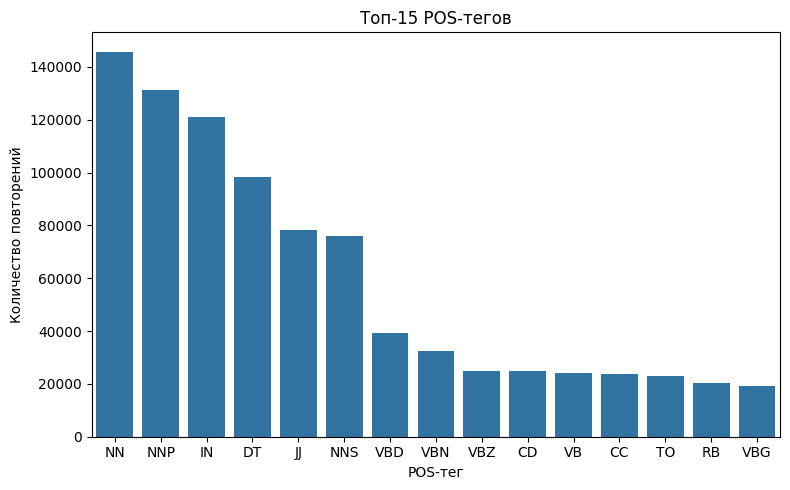

In [43]:
# получаем список всех тегов, кроме пунктуаций
all_pos = [tag for sublist in df['POS_list'] for tag in sublist if tag not in [".", ","]]
# считаем количество каждого тега
pos_counts = Counter(all_pos)
# выбираем 15 наиболее встречающихся тегов
top_pos = dict(pos_counts.most_common(15))


plt.figure(figsize=(8, 5))
sns.barplot(x=top_pos.keys(), y=top_pos.values())
plt.title('Топ-15 POS-тегов');
plt.xlabel('POS-тег')
plt.ylabel('Количество повторений')
plt.tight_layout()


Видим, что преимущественно в POS теги состоят из существительных, предлогов, союзов и прилагательных.

Далее взглянем на распределение NER тегов. Построим диаграмму

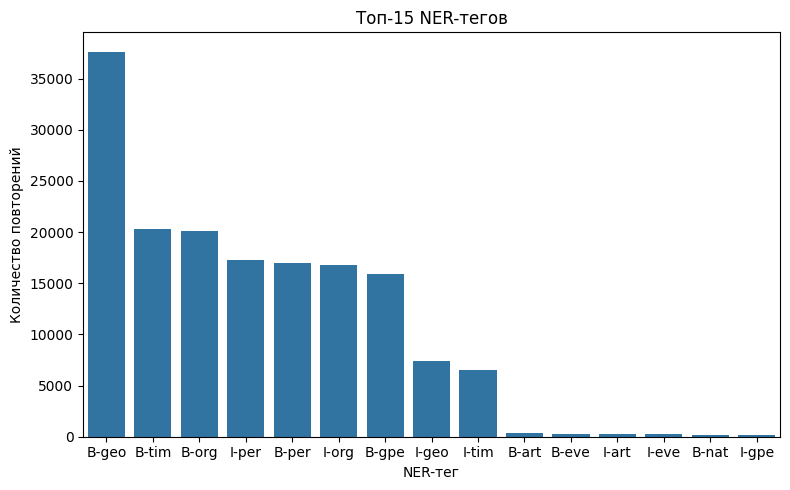

In [44]:
# получаем список всех тегов и считаем их количество
all_tags = [tag for sublist in df['Tag_list'] for tag in sublist if tag != "O"]
tag_counts = Counter(all_tags)
# выбираем 15 наиболее встречающихся тегов
top_tags = dict(tag_counts.most_common(15))

plt.figure(figsize=(8, 5))
sns.barplot(x=top_tags.keys(), y=top_tags.values())
plt.title('Топ-15 NER-тегов');
plt.xlabel('NER-тег')
plt.ylabel('Количество повторений')
plt.tight_layout()


По диаграмме видно, что больше всего в данных имеются следующие сущности: географические места, времена и организаций.